In [4]:
import pandas as pd
from config import config
import numpy as np
import matplotlib.pyplot as plt
from pipeline import visualisation_pipeline, ml_testing
from pipeline import rf_pipeline, lr_pipeline, sm_rf_pipeline, sm_lr_pipeline
from helpers import get_meta_columns, plot_categoricial, plot_discrete, plot_continuous
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, plot_confusion_matrix
sns.set_style("whitegrid")

In [5]:
def get_data(mode='train'):
    """gets the training or testing data
    encodes the target variable to binary
    returns: DataFrame
    """
    # reads in the data
    if mode == 'train':
        df = pd.read_csv(config.TRAIN_DIR, names=get_meta_columns(), na_values=' ?')
    else:
        df = pd.read_csv(config.TEST_DIR, names=get_meta_columns(), na_values=' ?')
        
    # encodes the target variable as binary
    df[config.TARGET] = df[config.TARGET].map(config.TARGET_ENCODING)
    return df

data = get_data()
 
# splits the data in to a training and validation set
X_train, X_test, y_train, y_test = train_test_split(
         data[config.FEATURES], data[config.TARGET], test_size=0.2, random_state=0
         )  

In [3]:
def process_data_visualisation(X_train, y_train):
    """Transforms data for visualisations
    uses a visualisation pipeline to preprocess the data
    visualisation pipeline: 
        Encodes NA values,
        Removes duplicate columns
        Performs Feature Engineering,
        Ordinal encoding for Categorical variables
    returns: None
    """
    x_train_processed = visualisation_pipeline.fit_transform(X_train[config.FEATURES], y_train)
    return pd.DataFrame(pd.concat([x_train_processed, y_train], axis=1))

plotting_df = process_data_visualisation(X_train, y_train)

----Categorical Variables -----


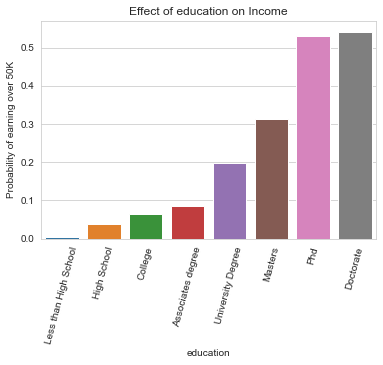

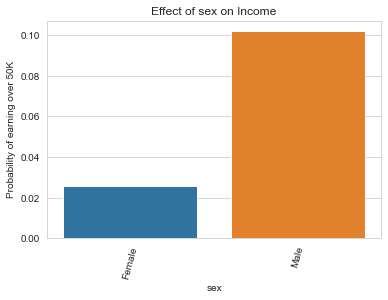

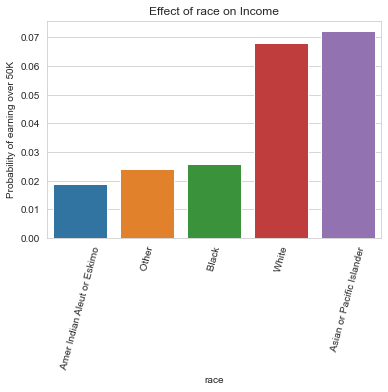

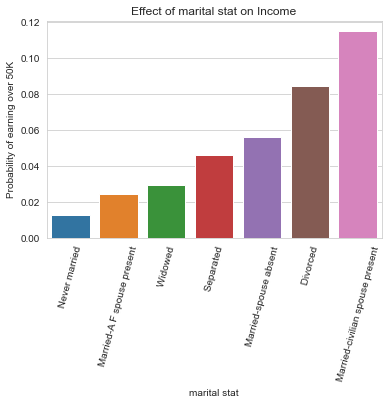

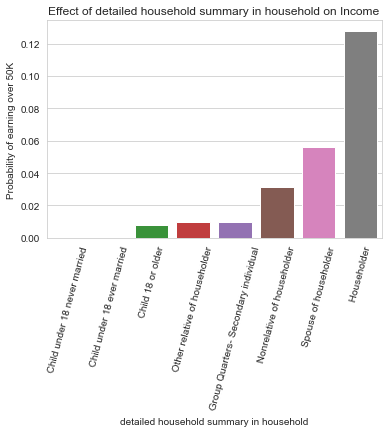

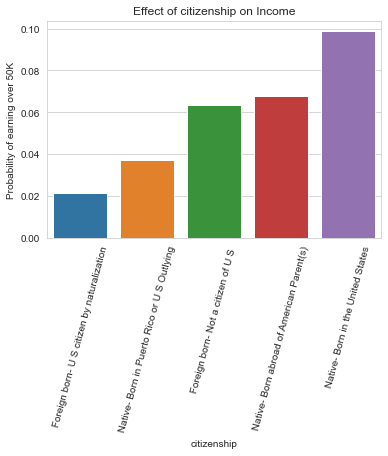

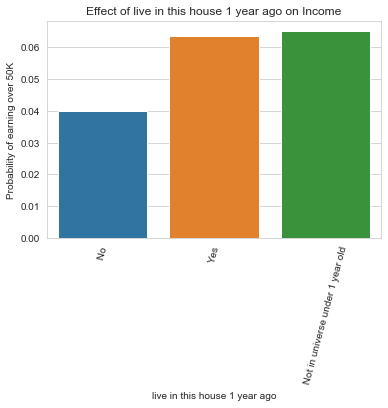

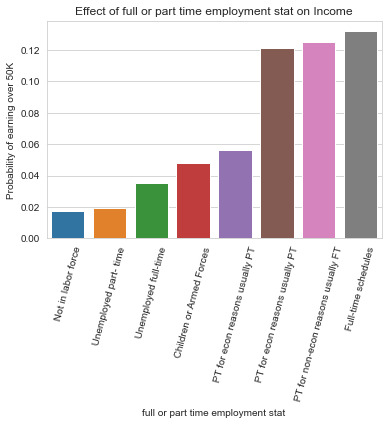

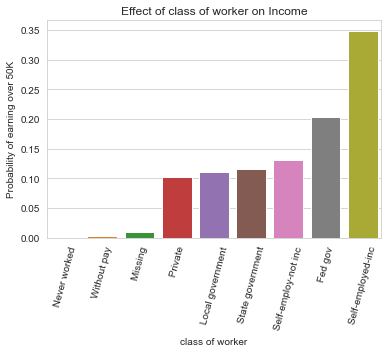

In [4]:
print('----Categorical Variables -----')
for var in config.VIS_CATEGORICAL_VALS:
    if var not in config.CATEGORICAL_VALS_NOT_PLOTTED:
        plot_categoricial(plotting_df, var)

----Discrete Variables -----


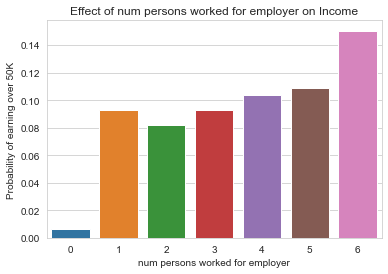

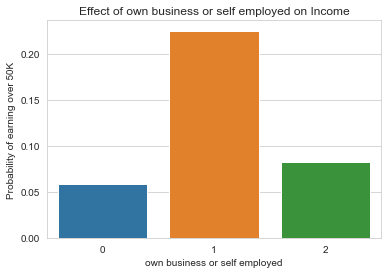

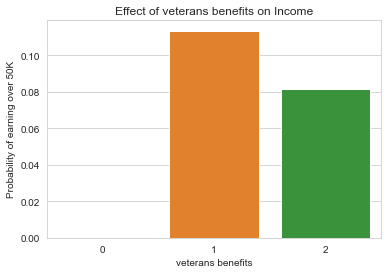

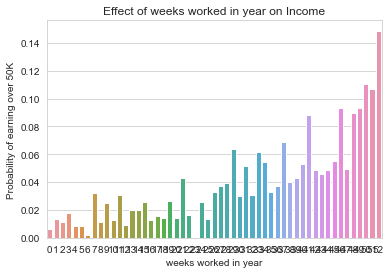

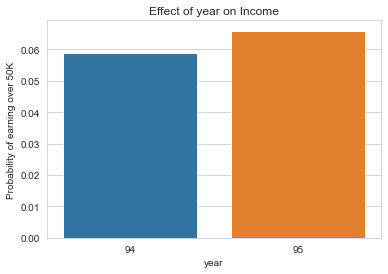

In [6]:
print('----Discrete Variables -----')
for var in config.DISCRETE_NUMERIC_VARS:
    if var not in config.DISCRETE_NOT_PLOTTED:
        plot_discrete(plotting_df, var)

----Continuous Variables -----


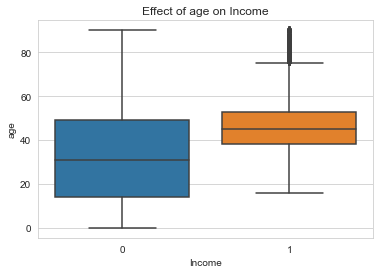

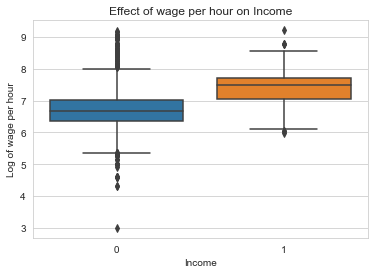

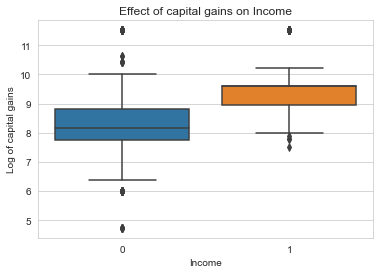

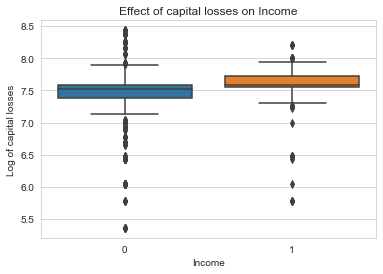

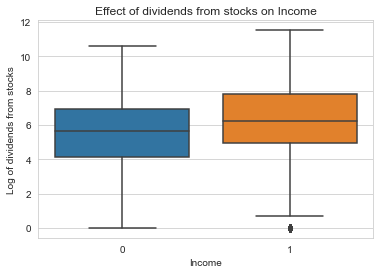

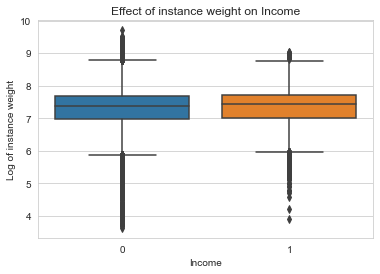

In [5]:
print('----Continuous Variables -----')
for var in config.CONTINUOUS_NUMERIC_VARS:
    plot_continuous(plotting_df, var)

In [3]:
def train_models( X_train, X_test, y_train, y_test):
    """Trains the models using sklearn pipelines
    Preprocessing steps shared by all pipelines are:
        1. Encode Not in universe as np.NAN
        2. Fill NA's with "missing"
        3. Encode Categorical as ordinal
        4. Encode education using feature engineering
        5. log transform skewed numeric variables
        6. Normalises all variable using min max
    Variability in resampling methods:
        1. No method
        2. SMOTE (Synthetic 
    returns: Dict, DataFrame
    """	
    models = {
        'Random_Forest': rf_pipeline,
        'Smote_Random_Forest': sm_rf_pipeline,
        'Logistic Regression': lr_pipeline,
        'Smote_Logistic_Regression': sm_lr_pipeline
        }
    results = {
		'Model': [],
		'Accuracy': [],
		'F1_Score': [],
		'Recall_Score': []
	}
    
    
    for key in models:
        models[key].fit(X_train, y_train)
        y_pred = models[key].predict(X_test)
        results['Model'].append(key)
        results['Accuracy'].append(accuracy_score(y_test, y_pred))
        results['F1_Score'].append(f1_score(y_test, y_pred))
        results['Recall_Score'].append(recall_score(y_test, y_pred))
    results = pd.DataFrame(results)
    print(results)
    return models, results

models, results = train_models(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

                       Model  Accuracy  F1_Score  Recall_Score
0              Random_Forest  0.955845  0.539467      0.425918
1        Smote_Random_Forest  0.949505  0.564701      0.539414
2        Logistic Regression  0.951485  0.478167      0.366075
3  Smote_Logistic_Regression  0.851121  0.417149      0.877425


Accuracy Score:0.9470439646358333
F1 Score:0.5689809904544343
Recall Score:0.5636922082120919


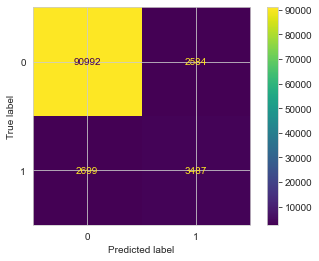

In [25]:
# Gets the test set data
test_data = get_data(mode='test')

# selects the best model
best_model = models[results.Model[results.Recall_Score.idxmax()]]


def get_performance(model, data) -> None:
    """plots performance of the model
    based on dataset provided
    returns: None"""
    y_pred = model.predict(data[config.FEATURES])
    y_test = data[config.TARGET]
    results = {
		'Accuracy': [],
		'F1_Score': [],
		'Recall_Score': []
	}

    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1_Score'].append(f1_score(y_test, y_pred))
    results['Recall_Score'].append(recall_score(y_test, y_pred))
    print(pd.DataFrame(results))
    plot_confusion_matrix(model, data[config.FEATURES], data[config.TARGET])
    plt.show()

get_performance(best_model, test_data)

In [6]:
df = ml_testing.fit_transform(X_train, y_train)
# corr_matrix = df.corr().abs()
# 
# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# 
# # Find features with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
# list(to_drop)
# # Drop features 
# # df.drop(to_drop, axis=1, inplace=True)
# 
df.shape

NameError: name 'corr_matrix' is not defined